https://www.tensorflow.org/tutorials/load_data/images

In [1]:
import tensorflow as tf
import numpy as np

dataset_dir = 'ISIC2018_Task1-2_Training_Data/'
input_dir = dataset_dir + 'ISIC2018_Task1-2_Training_Input_x2/'
groundtruth_dir = dataset_dir + 'ISIC2018_Task1_Training_GroundTruth_x2/'

In [2]:
ls $dataset_dir

ISIC2018_Task1-2_Training_Input_x2/     ISIC2018_Task1_Training_GroundTruth_x2/


In [3]:
import glob

input_filenames = glob.glob(input_dir + '/*.jpg')
input_filenames = sorted(input_filenames)

groundtruth_filenames = glob.glob(groundtruth_dir + '/*.png')
groundtruth_filenames = sorted(groundtruth_filenames)

# sanity check
assert len(input_filenames) == len(groundtruth_filenames)
test_size = int(len(input_filenames) * .2)

In [4]:
# input_filenames[-5:], groundtruth_filenames[-5:]
input_filenames = input_filenames[:15] #
groundtruth_filenames = groundtruth_filenames[:15] #
test_size = int(len(input_filenames) * .2)

train_images = input_filenames[2*test_size:]
train_labels = groundtruth_filenames[2*test_size:]

val_images = input_filenames[test_size:2*test_size]
val_labels = groundtruth_filenames[test_size:2*test_size]

test_images = input_filenames[:test_size]
test_labels = groundtruth_filenames[:test_size]

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [6]:
def map_fn(image_filename, label_filename):
    # # input image
    img = tf.io.read_file(image_filename)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256, 256))
    img = img / 255.
    # img = img[np.newaxis, :, :, :]

    # ground truth image
    label = tf.io.read_file(label_filename)
    label = tf.io.decode_jpeg(label, channels=1)
    label = tf.image.resize(label, (256, 256))
    label = label / 255.
    label = tf.cast(label > 0.5, dtype=tf.float32) # mask
        
    return img, label


In [7]:
train_ds = train_ds.map(map_fn).shuffle(20)
val_ds = val_ds.map(map_fn).shuffle(20)
test_ds = test_ds.map(map_fn).shuffle(20)

train_ds = train_ds.batch(4)
val_ds = val_ds.batch(4)
test_ds = test_ds.batch(4)

In [8]:
for img, label in train_ds:
    print(img.shape)
    print(tf.reduce_max(img), tf.reduce_min(img)) # between 0.0 and 1.0
    print('\n')
    print(label.shape)
    print(tf.reduce_max(label), tf.reduce_min(label)) # only 0.0 and 1.0

    break

(4, 256, 256, 3)
tf.Tensor(0.972549, shape=(), dtype=float32) tf.Tensor(0.0078546265, shape=(), dtype=float32)


(4, 256, 256, 1)
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# visualization

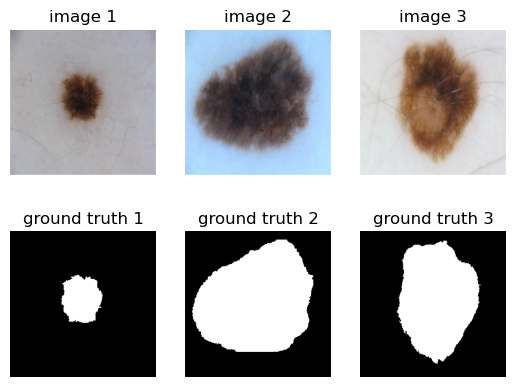

In [9]:
import numpy as np
import matplotlib.pyplot as plt

input_batch, groundtruth_batch = next(iter(test_ds.batch(3)))

# plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(input_batch[0][i].numpy())
    # plt.imshow(input_batch[i][0].numpy())
    plt.title('image ' + str(i+1))
    plt.axis('off')

    plt.subplot(2, 3, i+4)
    plt.imshow(groundtruth_batch[0][i].numpy(), cmap='gray')
    plt.title('ground truth ' + str(i+1))
    plt.axis('off')

plt.show()


In [10]:
# !pip install tensorflow_addons
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

from tensorflow_addons.layers import InstanceNormalization


def context_module(last_layer, n_filters, leaky_slope=1e-2, dropout_rate=0.3):

    # 1st
    norm1 = InstanceNormalization()(last_layer)
    leakyRelu1 = LeakyReLU(alpha=leaky_slope)(norm1)
    conv1 = Conv2D(filters=n_filters, kernel_size=3, strides=1, 
                   padding='same', use_bias=False)(leakyRelu1)

    dropout = Dropout(dropout_rate)(conv1)

    # 2nd
    norm2 = InstanceNormalization()(dropout)
    leakyRelu2 = LeakyReLU(alpha=leaky_slope)(norm2)
    conv2 = Conv2D(filters=n_filters, kernel_size=3, strides=1, 
                   padding='same', use_bias=False)(leakyRelu2)

    return conv2


def localization_module(last_layer, n_filters, leaky_slope=1e-2):

    conv1 = Conv2D(filters=n_filters, kernel_size=3, strides=1, 
                   padding='same')(last_layer)
    norm1 = InstanceNormalization()(conv1)
    leakyRelu1 = LeakyReLU(alpha=leaky_slope)(norm1)

    conv2 = Conv2D(filters=n_filters, kernel_size=1, strides=1, 
                   padding='valid')(leakyRelu1)
    norm2 = InstanceNormalization()(conv2)
    leakyRelu2 = LeakyReLU(alpha=leaky_slope)(norm2)

    return leakyRelu1, leakyRelu2

def improved_UNet(input_shape=(256, 256, 3), n_filters=16, n_classes=1, dropout_rate=0.3, leaky_slope=1e-2):
    # TODO: 256*256
    input_layer = Input(shape=input_shape)

    # context pathway 1
    con1_conv = Conv2D(n_filters*1, kernel_size=3, strides=1, padding='same', 
                       activation=LeakyReLU(leaky_slope), use_bias=False)(input_layer) # TODO: padding=same
    # con1_norm = InstanceNormalization()(con1_conv)
    con1_context = context_module(con1_conv, n_filters*1, leaky_slope, dropout_rate)
    con1_context += con1_conv
    # con1_context += con1_norm
    
    # context pathway 2
    con2_conv = Conv2D(n_filters*2, kernel_size=3, strides=2, padding='same', 
                       activation=LeakyReLU(leaky_slope), use_bias=False)(con1_context)
    con2_norm = InstanceNormalization()(con2_conv)
    con2_context = context_module(con2_norm, n_filters*2, leaky_slope, dropout_rate)
    con2_context += con2_conv
    # con2_context += con2_norm

    # context pathway 3 
    con3_conv = Conv2D(n_filters*4, kernel_size=3, strides=2, padding='same', 
                       activation=LeakyReLU(leaky_slope), use_bias=False)(con2_context)
    con3_norm = InstanceNormalization()(con3_conv)
    con3_context = context_module(con3_norm, n_filters*4, leaky_slope, dropout_rate)
    con3_context += con3_conv

    # localization pathway 1
    local1_up = UpSampling2D()(con3_context)
    local1_conv = Conv2D(n_filters*2, kernel_size=3, strides=1, padding='same', 
                         activation=LeakyReLU(leaky_slope), use_bias=False)(local1_up) # valid padding

    # localization pathway 2
    local2_concat = concatenate([local1_conv, con2_context]) # axis=3
    tmp_1, local2_localization = localization_module(local2_concat, n_filters*2, leaky_slope)
    local2_up = UpSampling2D()(local2_localization)
    local2_conv = Conv2D(n_filters*1, kernel_size=3, strides=1, padding='same', 
                         activation=LeakyReLU(leaky_slope), use_bias=False)(local2_up) #valid padding
    
    # final
    final_concat = concatenate([local2_conv, con1_context])
    final_conv = Conv2D(n_filters*2, kernel_size=3, strides=1, padding='same', 
                        activation=LeakyReLU(leaky_slope), use_bias=False)(final_concat) # valid padding 

    # segmentation
    seg_1 = Conv2D(n_classes, kernel_size=1, strides=1, padding='valid', 
                   activation=LeakyReLU(leaky_slope), use_bias=False)(tmp_1)
    seg_1_up = UpSampling2D(interpolation='bilinear')(seg_1)
    seg_final = Conv2D(n_classes, kernel_size=1, strides=1, padding='valid', 
                       activation=LeakyReLU(leaky_slope), use_bias=False)(final_conv) + seg_1_up

    # softmax
    pre = Activation('sigmoid')(seg_final)

    return Model(inputs = input_layer, outputs = pre)

model = improved_UNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 16) 32          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 16) 0           instance_normalization[0][0]     
______________________________________________________________________________________________

In [11]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.bool)
    y_pred = np.asarray(y_pred).astype(np.bool)
    intersection = np.logical_and(y_true, y_pred)
    return (2. * intersection.sum()) / (y_true.sum() + y_pred.sum())

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, 'accuracy'])
model_callback=tf.keras.callbacks.ModelCheckpoint(filepath='best_checkpoint', save_best_only= True,
                                                  save_weights_only=True, monitor = 'val_accuracy', mode='max')
# model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [13]:
# train_images.shape, train_labels.shape

In [14]:
history = model.fit(x=train_ds, epochs=15, validation_data=val_ds, shuffle=True,
                    batch_size=2, callbacks=[model_callback], verbose=1)

Epoch 1/15
3/3 [==============================] - 7s 1s/step - loss: 0.7300 - dice_coef: 0.3615 - accuracy: 0.5188 - val_loss: 0.8265 - val_dice_coef: 0.2996 - val_accuracy: 0.5975
Epoch 2/15
3/3 [==============================] - 3s 890ms/step - loss: 0.6116 - dice_coef: 0.3850 - accuracy: 0.9051 - val_loss: 0.8460 - val_dice_coef: 0.3048 - val_accuracy: 0.6215
Epoch 3/15
3/3 [==============================] - 3s 881ms/step - loss: 0.5835 - dice_coef: 0.4950 - accuracy: 0.9479 - val_loss: 0.7470 - val_dice_coef: 0.3160 - val_accuracy: 0.7734
Epoch 4/15
3/3 [==============================] - 3s 863ms/step - loss: 0.5775 - dice_coef: 0.4575 - accuracy: 0.9556 - val_loss: 0.7403 - val_dice_coef: 0.3230 - val_accuracy: 0.7823
Epoch 5/15
3/3 [==============================] - 3s 844ms/step - loss: 0.5727 - dice_coef: 0.4643 - accuracy: 0.9500 - val_loss: 0.7206 - val_dice_coef: 0.3317 - val_accuracy: 0.7916
Epoch 6/15
3/3 [==============================] - 3s 873ms/step - loss: 0.5552 - di